# Common Python Mistakes

This notebook contains 3 common mistakes made by both Python developers, as well as Data Scientists. This notebook is written not only to demonstrate these issues, but also to show how they may be fixed.

# Late Binding Closures

A closure in Python is a function object that has access to variables from its enclosing lexical scope, even when the function is called outside that scope. These variables are "closed over" by the closure, which is why it's called a "closure". Closures "remember" the values of these variables, even if they no longer exist in memory.

The term "late binding" refers to the time at which a variable name is looked up to find the variable's actual value. In Python, this lookup happens when the variable is used (i.e., when the closure is called), not when the function is defined - hence it's "late". This is why closures in Python capture the variables themselves, not their values at the time the function is defined.

In [12]:
def times_table():
    """
    Returns a list of functions that will give you
    the times table.

    >>> [f(5) for f in times_table()]
    >>> [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
    """
    table = []
    for i in range(10):
        def multiplier(x):  # This is a closure, because it has access to its outer lexical scope
            return i * x  # lookup for the variable i happens when the variable is used, not when it defined.

        table.append(multiplier)

    return table

In [13]:
[f(5) for f in times_table()]

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

In [14]:
import argparse
import os

import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter

from IPython.display import display

SIGMAS = list(range(1, 10))


def create_pipeline(*operations):
    def pipeline(data):
        for operation in operations:
            data = operation(data)
        return data

    return pipeline


def normalize(image):
    return image / 255


def add_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    return np.clip(image + noise, 0, 1)


def transform_image(image_path):
    # Open the image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_np = np.array(image)

    # Create blur operations with different sigma values
    blur_operations = [(lambda image: gaussian_filter(image, sigma+1)) for sigma in SIGMAS]

    # Create our pipeline with these operations
    operations = [normalize, add_noise] + blur_operations
    pipeline = create_pipeline(*operations)

    # Apply it to our image
    processed_image_np = pipeline(image_np)

    # Convert back to the range 0-255 and PIL Image object
    processed_image_np = np.clip(processed_image_np * 255, 0, 255).astype(np.uint8)
    processed_image = Image.fromarray(processed_image_np)
    display(processed_image)


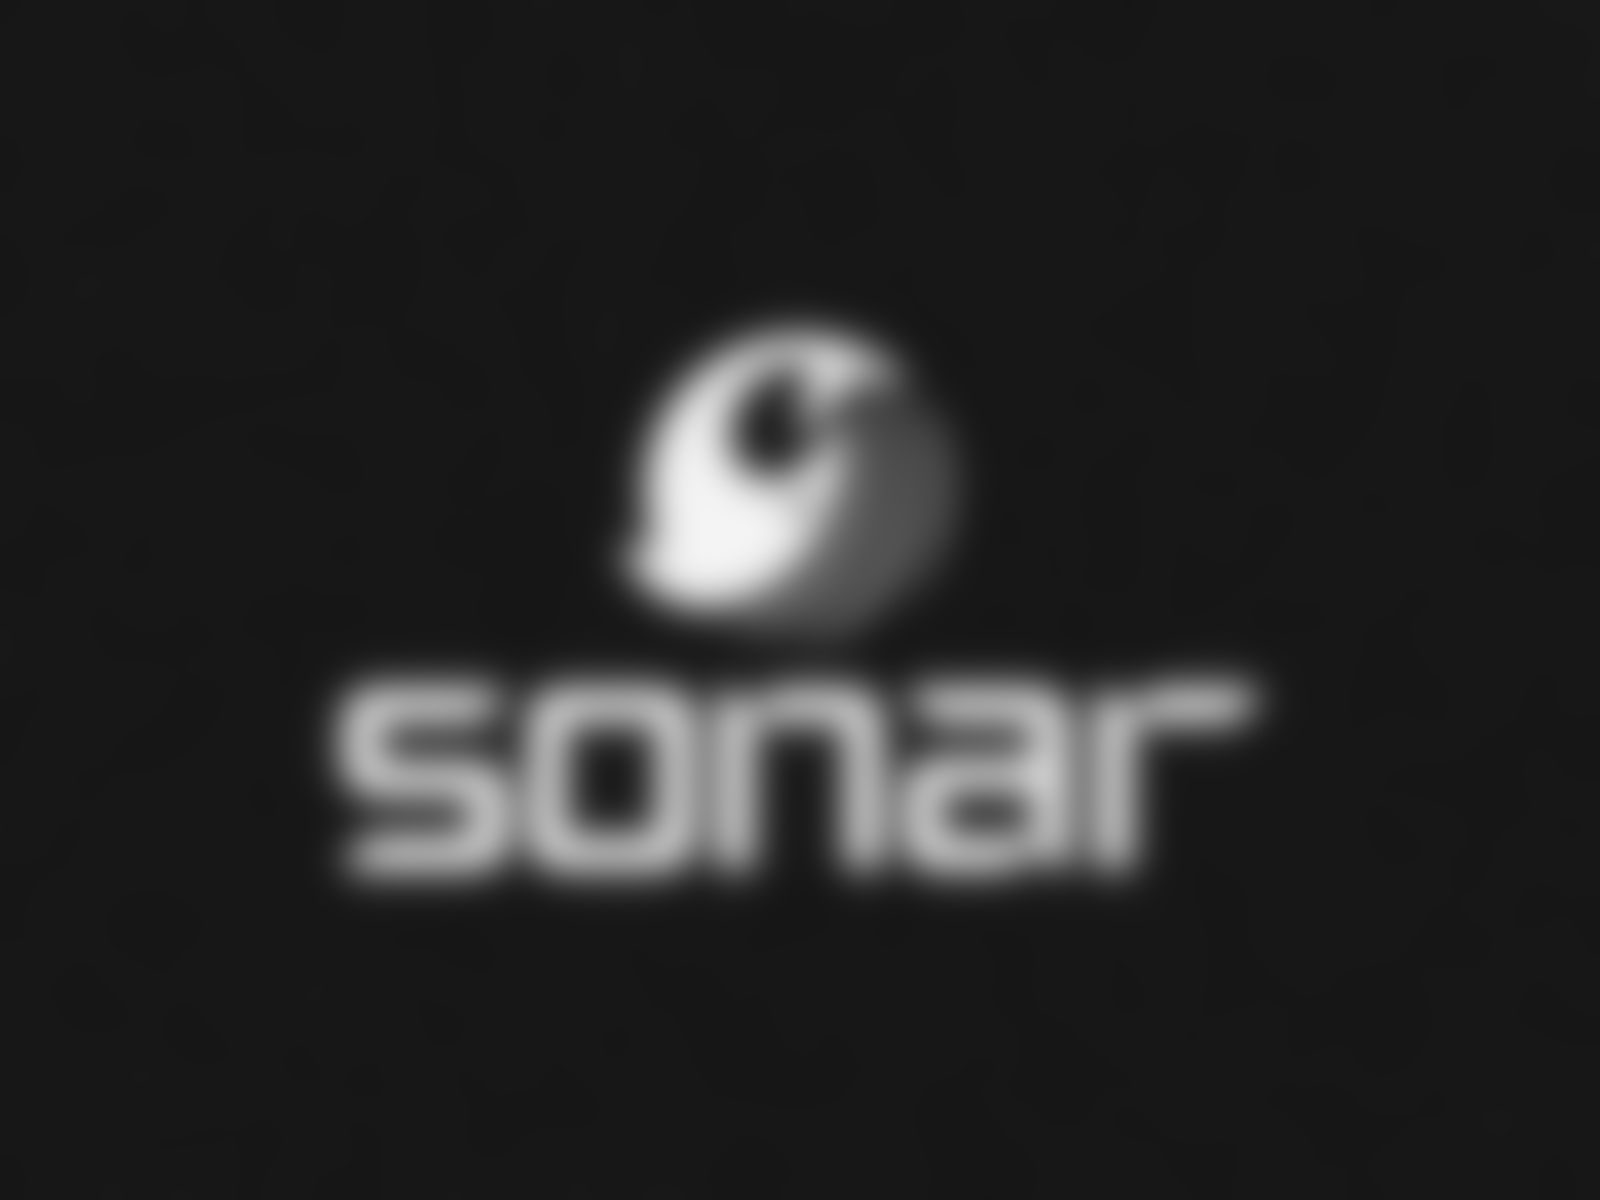

In [15]:
transform_image('./image.png')

In the example given, binding `sigma` too late can cause problems. It shows the big difference between using it as an argument inside the lambda and just passing it in from the outside. This function's goal is to make the image a bit blurry, but what happens is the image becomes totally blurry. This small image-changing function shows how forgetting about late bindings in closures can create big issues. Often, we realize these issues when it's already too late to fix them easily.

# Mutable Default Arguments

In Python, default arguments are evaluated only once, during function definition. This means that mutable objects, like lists or dictionaries, used as default arguments retain their state between function calls.

When you define a function with a mutable default argument, like this:

In [16]:
def add_item(item, items=[]):
    """
    A function that adds an item to an existing list.
    If a list is not provided, it creates a new item
    with that list added.
    """
    items.append(item)
    return items

In [17]:
v = add_item(1)
print(add_item(2))
print(add_item(3))
print(add_item(4))
print(v)

a = add_item(5)

[2]
[3]
[4]
[1]


The default argument items is initialized as an empty list only when the function is defined. Subsequent calls to the function using the default argument will refer to the same list object, which retains its state across function calls, as showin in the output above.

# Integer Caching

Althoug the `is` operator can seem like it serves the same function as the `==` operator, they are different. The `is` operator checks for identity, not equality. This means that `a is b` checks whether `a` and `b` refer to the exact same object in memory, not whether `a` and `b` have the same value.

This might seem obvious, but it can lead to some surprises due to Python's optimization for small integers and interned strings:

In [18]:
def something():

    a = 10

    print(a == 10)
    print(a is 10)

    c = 123456

    print(c == 123456)
    print(c is 123456)

something()


True
True
True
True


<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/tc/yt_dncdj2msczm5hhsmnbzw40000gn/T/ipykernel_18786/670719100.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  print(a is 10)
/var/folders/tc/yt_dncdj2msczm5hhsmnbzw40000gn/T/ipykernel_18786/670719100.py:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  print(c is 123456)


In general, it's best to use is when you want to check object identity (i.e., whether two variables refer to the exact same object), and `==` when you want to compare values.